In [1]:
# Standard library imports
import argparse
import sys
import os
import json
import warnings
import time

# Third-party imports
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb
from accelerate import Accelerator
from accelerate import DistributedDataParallelKwargs
from transformers import get_linear_schedule_with_warmup, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

# Add project root to path
import os
current_dir = os.getcwd()
project_root = os.path.dirname(os.path.dirname(current_dir))
sys.path.append(project_root)

# Project imports
from src.utils import set_seed, create_transforms
from src.multimodal.multimodal_training_config import MultimodalTrainingConfig
from src.multimodal.mllm import MLLM
from src.datasets.imagenet.imagenet_dataset import ImageNetDataset, MultimodalCollator
from src.datasets.color.color_dataset import ColorDataset

/users/sboppana/data/sboppana/multimodal_concept_learning/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/users/sboppana/data/sboppana/multimodal_concept_learning/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annota

In [2]:
def load_token_embeddings(results_dir: str):
    """
    Load token embeddings from all epochs of a trained model.
    
    Args:
        results_dir: Path to the results directory containing the trained model
        
    Returns:
        dict: Dictionary mapping epoch names to embedding matrices (torch tensors)
    """
    models_dir = os.path.join(results_dir, "models")
    
    # Load training config
    config_path = os.path.join(models_dir, "training_config.json")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Training config not found at {config_path}")
    
    with open(config_path, 'r') as f:
        config_dict = json.load(f)
    
    # Create config object
    config = MultimodalTrainingConfig.from_params(config_dict)
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(config.language_model_name, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Initialize model
    model = MLLM(
        vision_model_name=config.vision_model_name,
        language_model_name=config.language_model_name,
        vision_path=config.vision_path,
        num_vision_tokens=config.num_vision_tokens,
        labels_mapping_path=config.labels_mapping_path
    )
    
    # Dictionary to store embeddings for each epoch
    embeddings_by_epoch = {}
    
    # Load initial model
    initial_model_path = os.path.join(models_dir, "initial_model.pt")
    if os.path.exists(initial_model_path):
        model.load_state_dict(torch.load(initial_model_path, map_location='cpu'))
        model.eval()
        
        # Extract embedding matrix
        input_embeddings = model.language_model.get_input_embeddings()
        embeddings_by_epoch["initial"] = input_embeddings.weight.clone()
        print(f"Loaded initial model embeddings: {input_embeddings.weight.shape}")
    
    # Load epoch models (but not best_model.pt)
    epoch_files = [f for f in os.listdir(models_dir) if f.startswith("epoch_") and f.endswith("_model.pt")]
    epoch_files.sort(key=lambda x: int(x.split("_")[1]))  # Sort by epoch number
    
    for epoch_file in epoch_files:
        epoch_num = epoch_file.split("_")[1]
        epoch_path = os.path.join(models_dir, epoch_file)
        
        model.load_state_dict(torch.load(epoch_path, map_location='cpu'))
        model.eval()
        
        # Extract embedding matrix
        input_embeddings = model.language_model.get_input_embeddings()
        embeddings_by_epoch[f"epoch_{epoch_num}"] = input_embeddings.weight.clone()
        print(f"Loaded epoch {epoch_num} embeddings: {input_embeddings.weight.shape}")
    
    print(f"Total loaded {len(embeddings_by_epoch)} embedding matrices")
    return embeddings_by_epoch
    

In [ ]:
def setup_tokenizer_and_mapping(config):
    """
    Reproduce the tokenizer setup from training, including OOD tokens.
    
    Args:
        config: MultimodalTrainingConfig object
        
    Returns:
        tuple: (tokenizer, labels_mapping, ood_tokens, regular_tokens)
    """
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(config.language_model_name, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Load labels mapping
    labels_mapping = None
    ood_tokens = []
    regular_tokens = []
    
    if config.labels_mapping_path and os.path.exists(config.labels_mapping_path):
        with open(config.labels_mapping_path, 'r') as f:
            labels_mapping = json.load(f)
        
        # Extract OOD tokens (those starting with "<ood")
        ood_tokens = [label for label in labels_mapping.values() if label.startswith("<ood")]
        
        # Extract regular tokens (not OOD)
        regular_tokens = [label for label in labels_mapping.values() if not label.startswith("<ood")]
        
        # Add OOD tokens to tokenizer (this is what happens during training)
        if ood_tokens:
            tokenizer.add_tokens(ood_tokens)
            print(f"Added {len(ood_tokens)} OOD tokens to tokenizer")
            print(f"OOD tokens: {ood_tokens}")
        else:
            print("No OOD tokens found in labels mapping")
    
    print(f"Tokenizer vocabulary size: {len(tokenizer)}")
    print(f"Regular tokens: {len(regular_tokens)}")
    print(f"OOD tokens: {len(ood_tokens)}")
    
    return tokenizer, labels_mapping, ood_tokens, regular_tokens


: 

In [ ]:
# Load embeddings and setup tokenizer with OOD tokens
results_dir = "/users/sboppana/data/sboppana/multimodal_concept_learning/results/multimodal/color/96_colors_375"

# Load embeddings from all epochs
embeddings_by_epoch = load_token_embeddings(results_dir)

# Load config to setup tokenizer
config_path = os.path.join(results_dir, "models", "training_config.json")
with open(config_path, 'r') as f:
    config_dict = json.load(f)
config = MultimodalTrainingConfig.from_params(config_dict)

# Setup tokenizer with OOD tokens
tokenizer, labels_mapping, ood_tokens, regular_tokens = setup_tokenizer_and_mapping(config)

print(f"\n=== Token Analysis ===")
print(f"Total vocabulary size: {len(tokenizer)}")
print(f"Regular tokens: {len(regular_tokens)}")
print(f"OOD tokens: {len(ood_tokens)}")

# Show some examples
if regular_tokens:
    print(f"\nSample regular tokens: {regular_tokens[:5]}")
if ood_tokens:
    print(f"\nSample OOD tokens: {ood_tokens[:5]}")

# Get token IDs for analysis
ood_token_ids = [tokenizer.convert_tokens_to_ids(token) for token in ood_tokens]
regular_token_ids = [tokenizer.convert_tokens_to_ids(token) for token in regular_tokens]

print(f"\nOOD token IDs: {ood_token_ids}")
print(f"Regular token IDs: {regular_token_ids[:10]}...")  # Show first 10


`torch_dtype` is deprecated! Use `dtype` instead!


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Loaded initial model embeddings: torch.Size([262235, 1152])
Loaded epoch 0 embeddings: torch.Size([262235, 1152])
Loaded epoch 1 embeddings: torch.Size([262235, 1152])


Analyzing 48 tokens across 4 epochs
initial: (48, 1152)
epoch_0: (48, 1152)
epoch_1: (48, 1152)
epoch_2: (48, 1152)

Fitting UMAP on initial embeddings...


/users/sboppana/data/sboppana/multimodal_concept_learning/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Transformed initial: (48, 2)
Transformed epoch_0: (48, 2)
Transformed epoch_1: (48, 2)
Transformed epoch_2: (48, 2)
Extracted RGB colors for 48 tokens


/tmp/ipykernel_405402/3628317357.py:79: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, c=[color], marker=marker, s=size, alpha=0.8, edgecolors='black', linewidth=0.5)
/tmp/ipykernel_405402/3628317357.py:88: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([], [], c='black', marker='x', s=80, label='OOD', edgecolors='black')


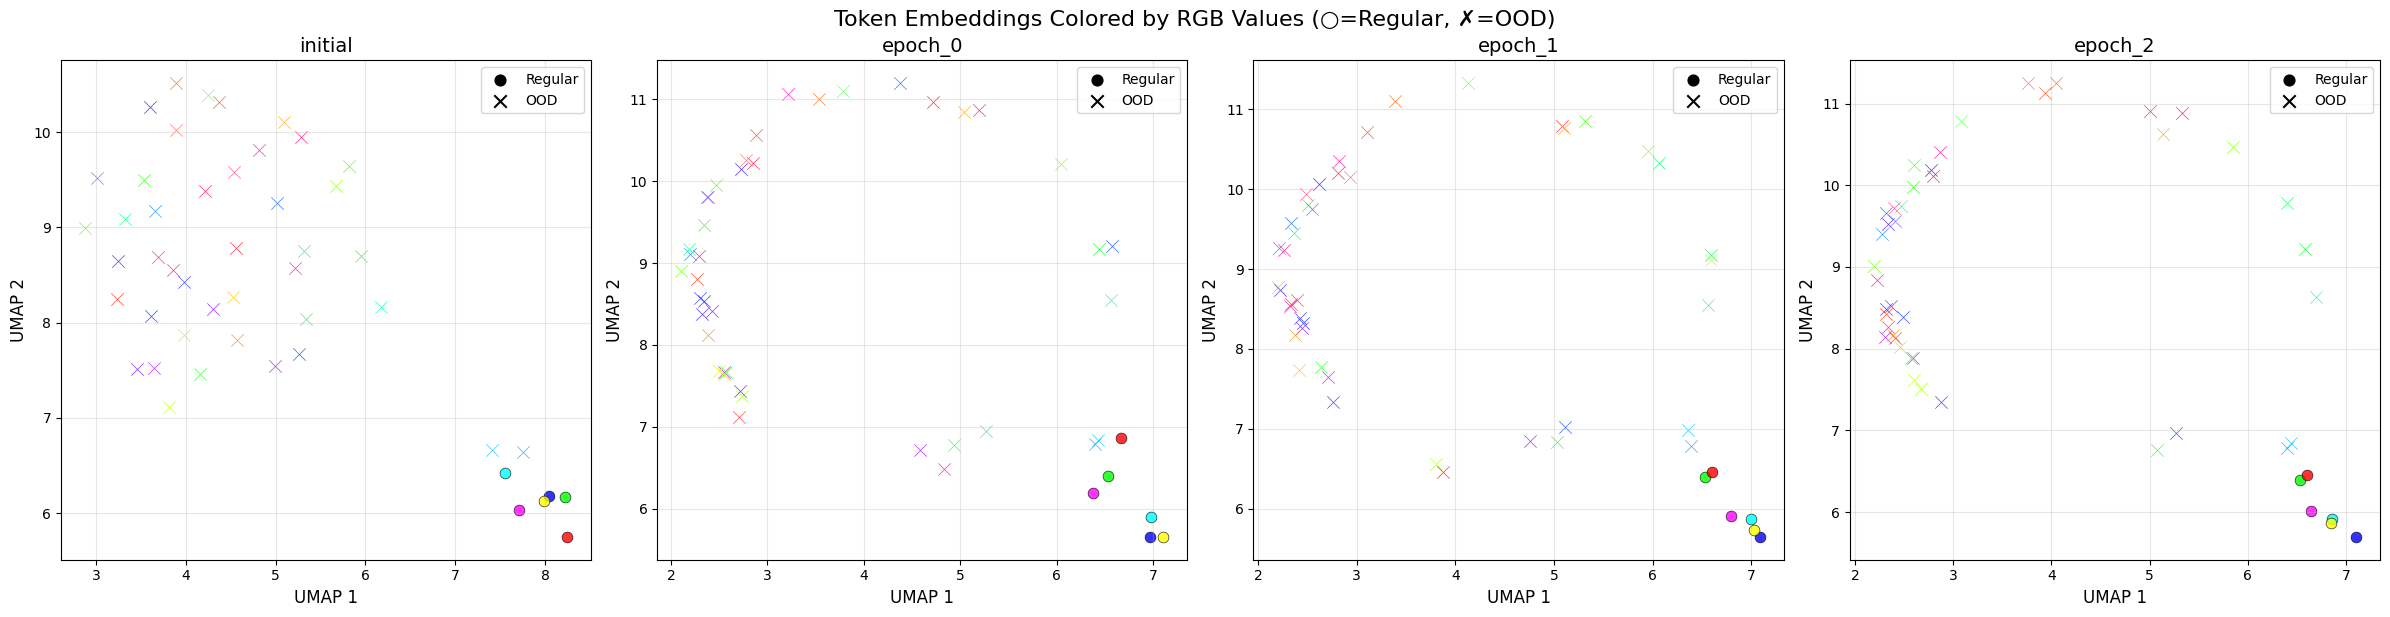


=== RGB Color Information ===
Regular tokens:
  blue: RGB(0.000, 0.000, 1.000)
  green: RGB(0.000, 1.000, 0.000)
  cyan: RGB(0.000, 1.000, 1.000)
  red: RGB(1.000, 0.000, 0.000)
  magenta: RGB(1.000, 0.000, 1.000)
  yellow: RGB(1.000, 1.000, 0.000)

OOD tokens (first 5):
  <ood 1>: RGB(0.000, 0.502, 1.000)
  <ood 2>: RGB(0.000, 0.627, 1.000)
  <ood 3>: RGB(0.000, 0.753, 1.000)
  <ood 4>: RGB(0.000, 1.000, 0.502)
  <ood 5>: RGB(0.000, 1.000, 0.627)
  ... and 37 more OOD tokens


In [ ]:
# Create RGB-colored UMAP plots with shape differentiation for regular vs OOD
import re
import umap

def extract_rgb_from_mapping(labels_mapping, token):
    """Extract RGB values for a given token from the labels mapping."""
    for rgb_key, token_value in labels_mapping.items():
        if token_value == token:
            # Parse RGB values from format "r{red}g{green}b{blue}"
            match = re.match(r'r(\d+)g(\d+)b(\d+)', rgb_key)
            if match:
                r, g, b = map(int, match.groups())
                return (r/255.0, g/255.0, b/255.0)  # Normalize to [0,1]
    return (0.5, 0.5, 0.5)  # Default gray if not found

# Get all token IDs for regular and OOD tokens
all_token_ids = ood_token_ids + regular_token_ids
all_token_names = ood_tokens + regular_tokens
token_types = ['OOD'] * len(ood_tokens) + ['Regular'] * len(regular_tokens)

print(f"Analyzing {len(all_token_ids)} tokens across {len(embeddings_by_epoch)} epochs")

# Create a dictionary to store embeddings for each epoch
epoch_embeddings = {}

for epoch_name, embedding_matrix in embeddings_by_epoch.items():
    # Extract embeddings for our tokens of interest
    token_embeddings = embedding_matrix[all_token_ids].detach().cpu().float().numpy()
    epoch_embeddings[epoch_name] = token_embeddings
    print(f"{epoch_name}: {token_embeddings.shape}")

# Create UMAP reducer (fit on initial embeddings for consistency)
print("\nFitting UMAP on initial embeddings...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(15, len(all_token_ids)-1))
initial_embeddings = epoch_embeddings['initial']
reducer.fit(initial_embeddings)

# Transform all epochs using the same UMAP fit
epoch_projections = {}
for epoch_name, embeddings in epoch_embeddings.items():
    projections = reducer.transform(embeddings)
    epoch_projections[epoch_name] = projections
    print(f"Transformed {epoch_name}: {projections.shape}")

# Extract RGB colors for all tokens
token_colors = []
for token in all_token_names:
    rgb_color = extract_rgb_from_mapping(labels_mapping, token)
    token_colors.append(rgb_color)

print(f"Extracted RGB colors for {len(token_colors)} tokens")

# Create enhanced UMAP plots with RGB colors and shape differentiation
epochs = list(epoch_projections.keys())
n_epochs = len(epochs)
fig, axes = plt.subplots(1, n_epochs, figsize=(6*n_epochs, 6))

if n_epochs == 1:
    axes = [axes]

for i, epoch_name in enumerate(epochs):
    ax = axes[i]
    projections = epoch_projections[epoch_name]
    
    # Plot each token with its RGB color and appropriate shape
    for j, (x, y) in enumerate(projections):
        color = token_colors[j]
        token_type = token_types[j]
        token_name = all_token_names[j]
        
        # Use different shapes for regular vs OOD
        if token_type == 'OOD':
            marker = 'x'  # X for OOD tokens
            size = 80
        else:
            marker = 'o'  # Circle for regular tokens
            size = 60
        
        ax.scatter(x, y, c=[color], marker=marker, s=size, alpha=0.8, edgecolors='black', linewidth=0.5)

    ax.set_title(f'{epoch_name}', fontsize=14)
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.scatter([], [], c='black', marker='o', s=60, label='Regular', edgecolors='black')
    ax.scatter([], [], c='black', marker='x', s=80, label='OOD', edgecolors='black')
    ax.legend()

plt.tight_layout()
plt.suptitle('Token Embeddings Colored by RGB Values (○=Regular, ✗=OOD)', y=1.02, fontsize=16)
plt.show()

# Print RGB color information
print(f"\n=== RGB Color Information ===")
print("Regular tokens:")
for i, token in enumerate(regular_tokens):
    rgb = token_colors[all_token_names.index(token)]
    print(f"  {token}: RGB({rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f})")

print(f"\nOOD tokens (first 5):")
for i, token in enumerate(ood_tokens[:5]):
    rgb = token_colors[all_token_names.index(token)]
    print(f"  {token}: RGB({rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f})")
print(f"  ... and {len(ood_tokens) - 5} more OOD tokens")


=== Regular Tokens UMAP Analysis ===
initial: (6, 1152)
epoch_0: (6, 1152)
epoch_1: (6, 1152)
epoch_2: (6, 1152)

Fitting UMAP on regular tokens from initial epoch...


/users/sboppana/data/sboppana/multimodal_concept_learning/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Transformed initial: (6, 2)
Transformed epoch_0: (6, 2)
Transformed epoch_1: (6, 2)
Transformed epoch_2: (6, 2)


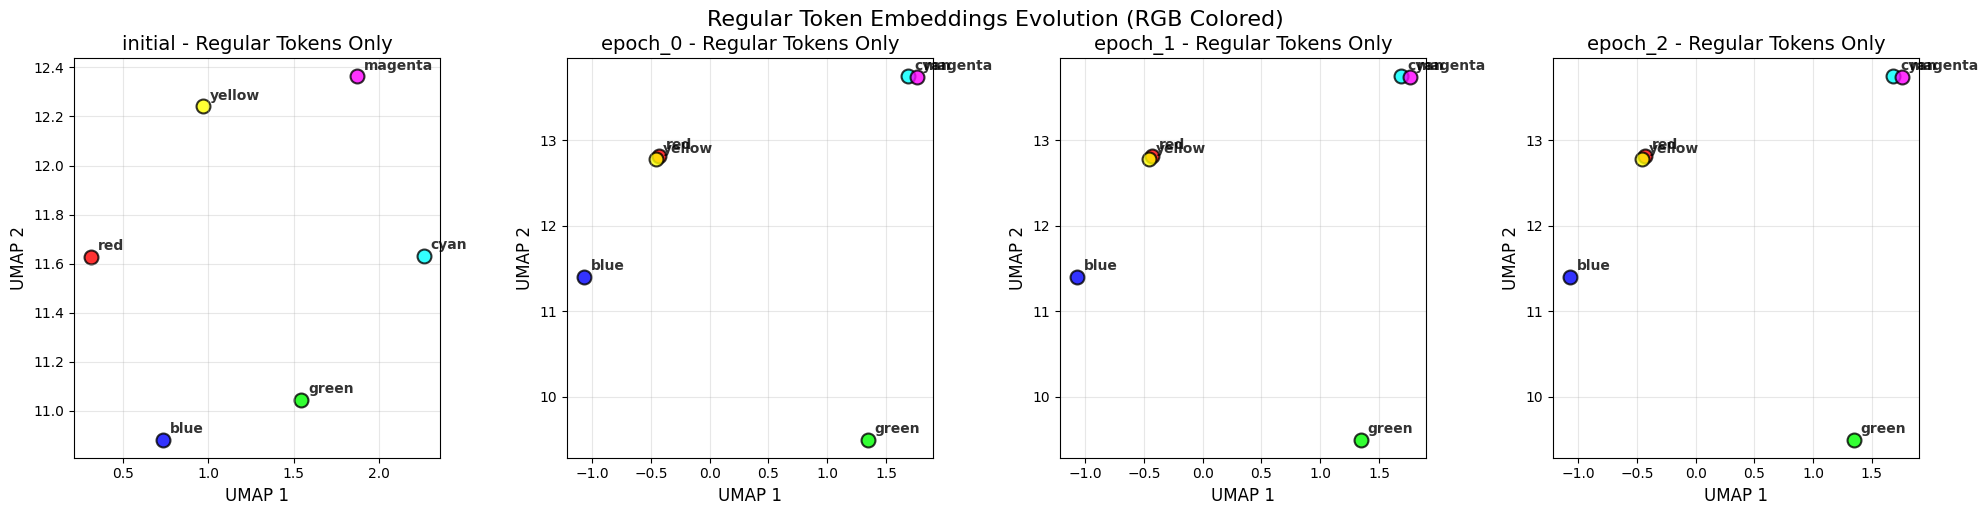


=== Regular Token Distance Analysis ===

initial:
  blue ↔ green: 0.827
  blue ↔ cyan: 1.703
  blue ↔ red: 0.854
  blue ↔ magenta: 1.867
  blue ↔ yellow: 1.378
  green ↔ cyan: 0.927
  green ↔ red: 1.363
  green ↔ magenta: 1.358
  green ↔ yellow: 1.327
  cyan ↔ red: 1.952
  cyan ↔ magenta: 0.832
  cyan ↔ yellow: 1.431
  red ↔ magenta: 1.724
  red ↔ yellow: 0.900
  magenta ↔ yellow: 0.910

epoch_0:
  blue ↔ green: 3.071
  blue ↔ cyan: 3.619
  blue ↔ red: 1.551
  blue ↔ magenta: 3.677
  blue ↔ yellow: 1.508
  green ↔ cyan: 4.258
  green ↔ red: 3.759
  green ↔ magenta: 4.264
  green ↔ yellow: 3.738
  cyan ↔ red: 2.314
  cyan ↔ magenta: 0.077
  cyan ↔ yellow: 2.351
  red ↔ magenta: 2.384
  red ↔ yellow: 0.044
  magenta ↔ yellow: 2.421

epoch_1:
  blue ↔ green: 3.071
  blue ↔ cyan: 3.619
  blue ↔ red: 1.551
  blue ↔ magenta: 3.677
  blue ↔ yellow: 1.508
  green ↔ cyan: 4.258
  green ↔ red: 3.759
  green ↔ magenta: 4.264
  green ↔ yellow: 3.738
  cyan ↔ red: 2.314
  cyan ↔ magenta: 0.077
  c

In [ ]:
# Create UMAP focused only on regular tokens
print("=== Regular Tokens UMAP Analysis ===")

# Extract embeddings for only regular tokens across epochs
regular_epoch_embeddings = {}
for epoch_name, embedding_matrix in embeddings_by_epoch.items():
    regular_token_embeddings = embedding_matrix[regular_token_ids].detach().cpu().float().numpy()
    regular_epoch_embeddings[epoch_name] = regular_token_embeddings
    print(f"{epoch_name}: {regular_token_embeddings.shape}")

# Create UMAP reducer fit only on regular tokens from initial epoch
print("\nFitting UMAP on regular tokens from initial epoch...")
regular_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(5, len(regular_tokens)-1))
initial_regular_embeddings = regular_epoch_embeddings['initial']
regular_reducer.fit(initial_regular_embeddings)

# Transform all epochs using the same UMAP fit
regular_epoch_projections = {}
for epoch_name, embeddings in regular_epoch_embeddings.items():
    projections = regular_reducer.transform(embeddings)
    regular_epoch_projections[epoch_name] = projections
    print(f"Transformed {epoch_name}: {projections.shape}")

# Create subplots for each epoch showing only regular tokens
epochs = list(regular_epoch_projections.keys())
n_epochs = len(epochs)
fig, axes = plt.subplots(1, n_epochs, figsize=(5*n_epochs, 5))

if n_epochs == 1:
    axes = [axes]

for i, epoch_name in enumerate(epochs):
    ax = axes[i]
    projections = regular_epoch_projections[epoch_name]
    
    # Plot each regular token with its RGB color
    for j, (x, y) in enumerate(projections):
        token_name = regular_tokens[j]
        rgb_color = extract_rgb_from_mapping(labels_mapping, token_name)
        
        ax.scatter(x, y, c=[rgb_color], marker='o', s=100, alpha=0.8, 
                  edgecolors='black', linewidth=1.5)
        
        # Add token labels
        ax.annotate(token_name, (x, y), xytext=(5, 5), textcoords='offset points', 
                   fontsize=10, alpha=0.8, fontweight='bold')

    ax.set_title(f'{epoch_name} - Regular Tokens Only', fontsize=14)
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Regular Token Embeddings Evolution (RGB Colored)', y=1.02, fontsize=16)
plt.show()

# Calculate distances between regular tokens
print(f"\n=== Regular Token Distance Analysis ===")
for epoch_name in epochs:
    projections = regular_epoch_projections[epoch_name]
    
    print(f"\n{epoch_name}:")
    for i, token1 in enumerate(regular_tokens):
        for j, token2 in enumerate(regular_tokens):
            if i < j:  # Avoid duplicates and self-comparison
                dist = np.linalg.norm(projections[i] - projections[j])
                print(f"  {token1} ↔ {token2}: {dist:.3f}")
